# Wrangling of Hot 100 Data

In this initial step I'll merge the raw data scraped from the [Billboard Hot 100 Charts](https://www.billboard.com/charts/hot-100/) with the songs' respective features from the [Spotify API Features Endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/).


In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob, iglob
import re
import time
from similarity.metric_lcs import MetricLCS # String Similarity https://github.com/luozhouyang/python-string-similarity
from similarity.ngram import NGram

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

GrayO = ["gray","orange","black"]
sns.set_palette(GrayO)

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.options.display.max_columns = 400

pd.options.display.max_rows = 400

twogram = NGram(2)
metric_lcs = MetricLCS()

In [2]:
# Switch Directory to ../data/interim/
current_dir = os.getcwd()
destination_dir = '/data/interim'
if current_dir[-len(destination_dir):] != destination_dir:
    os.chdir('..' + destination_dir)
else:
    print('already in correct directory: ',current_dir)
    
def switch_dir(data_subdir):
    print('switch to /data/' + data_subdir)
    os.chdir('../' + data_subdir)

The scraper has separated each chart into a separate file. These need to be merged into one comprehensive Dataframe. Each file contains 100 tracks.

In [3]:
filenames = glob('hot100/*.csv')
print("There is a total of {} files with 100 songs each.".format(len(filenames)))

target_path = '../interim/hot100_songs.csv'

try:
    # Read in Summary File is exists
    hot100_all = pd.read_csv(target_path,sep='\t',parse_dates=['date'])
except:
    # Read in all Subfiles
    hot100_dfs = [pd.read_csv(filepath,sep='\t',usecols=['date','rank','title','artist'],
                              parse_dates=['date']) for filepath in filenames]
    hot100_all = pd.concat(hot100_dfs)
    
    # Create Summary File for faster processing
    hot100_all.to_csv(target_path,sep='\t',index=False)

print("The total number of songs is {}.".format(len(hot100_all)))
hot100_all.head()

There is a total of 3167 files with 100 songs each.
The total number of songs is 316685.


,rank,date,title,artist
0,1,1967-07-08,Windy,The Association
1,2,1967-07-08,Little Bit O' Soul,The Music Explosion
2,3,1967-07-08,Can't Take My Eyes Off You,Frankie Valli
3,4,1967-07-08,San Francisco (Be Sure To Wear Flowers In Your...,Scott McKenzie
4,5,1967-07-08,Don't Sleep In The Subway,Petula Clark


We can see that 3167 files (100 songs each) shows a total of 15 missing songs. We'll look at those 15 songs further down in this analysis.

Next we'll add a few additional columns to enrich the information by track performance and artist performance:
    - reentry - Multiple non-consecutive listings on the Hot 100
    - streak - Consecutive length a song ranked in the Hot 100
    - ranked - Number of Times a song ranked in the Hot 100
    - week - A relative number to compare time on the Hot 100
    - leap - The biggest jump in rank from one week to the next
    - entry - Position it first appeared
    - exit - Position it last appeared
    - peak - Highest Position
    - low - Lowest Position

In [4]:
# Split Dates into year, month, day columns
def split_date(df,dt_col,prefix=False):
    """
    This function adds split date columns (year, month, day) to the dataframe. This is an inplace function.
    """
    if prefix:
        prefix = prefix
    else:
        prefix = ''
    df.loc[:,prefix + 'year'] = df.loc[:,dt_col].dt.year
    df.loc[:,prefix + 'month'] = df.loc[:,dt_col].dt.month
    df.loc[:,prefix + 'day'] = df.loc[:,dt_col].dt.day

split_date(hot100_all,'date')
hot100_all = hot100_all.loc[:,['rank','date','year','month','day','title','artist']]

In [5]:
def get_week(col):
    return pd.Series(np.arange(1,len(col) + 1))

hot100_all['week'] = hot100_all.sort_values(by=['title','artist','date']).groupby(by=['title','artist']).date.transform(get_week)

In [6]:
# Continuous or Not?
consecutive = hot100_all.loc[:,['title','artist','date','rank']].sort_values(by=['title','artist','date'])
consecutive['prev_week'] = consecutive.groupby(by=['title','artist']).date.shift()
consecutive['consecutive'] = (consecutive['date'] - consecutive['prev_week']) == '7 days'

## Reentry from consecutive column
reentry = consecutive.loc[:,['artist','title','consecutive']]
reentry = consecutive.loc[consecutive['consecutive'] == False,:].groupby(by=['artist','title']).count()['consecutive'] - 1
reentry = reentry.reset_index().rename(columns={'consecutive':'reentry'})
reentry['reentry'] = reentry['reentry'].astype(int)
reentry.loc[reentry['reentry'] == 0, 'reentry'] = 0

hot100_all = hot100_all.merge(reentry,on=['title','artist'],how='left')
reentry = ''

# Streak from consecutive columns
# use cumsum() if consecutive['consecutive'] == True and Reset to 0 if consecutive['consecutive'] == False
streak = consecutive.loc[:,['artist','title','consecutive']].copy()
streak['streak'] = streak.groupby( (streak['consecutive'] != 1).cumsum()).cumcount() + \
                  ( (streak['consecutive'] != 1).cumsum() == 0).astype(int) 
streak = streak.loc[:,['title','artist','streak']].groupby(by=['title','artist']).max().reset_index()

hot100_all = hot100_all.merge(streak,on=['title','artist'],how='left')
streak = ''
consecutive = ''

In [7]:
# Ranked
ranked = hot100_all.loc[:,['title','artist','rank']].groupby(by=['title','artist']).count().reset_index()
ranked.columns = ['title','artist','ranked']

hot100_all = hot100_all.merge(ranked,on=['title','artist'],how='left')
ranked = ''

In [8]:
# Entry
entry_date = hot100_all.loc[:,['title','artist','date','week']].groupby(by=['title','artist']).min().reset_index()
entry_date.rename(columns={'date': 'entry_date','week': 'entry_week'},inplace=True)
hot100_all = hot100_all.merge(entry_date,on=['title','artist'],how='left')

entry_rank = hot100_all.loc[hot100_all.date == hot100_all.entry_date,['artist','title','rank']]
entry_rank.rename(columns={'rank': 'entry'},inplace=True)

hot100_all = hot100_all.merge(entry_rank,on=['title','artist'],how='left')
entry_date = ''
entry_rank = ''

# Split Entry Date
split_date(hot100_all,'entry_date','entry_')

In [9]:
# Exit
exit_date = hot100_all.loc[:,['title','artist','date','week']].groupby(by=['title','artist']).max().reset_index()
exit_date.rename(columns={'date': 'exit_date','week': 'exit_week'},inplace=True)
hot100_all = hot100_all.merge(exit_date,on=['title','artist'],how='left')

exit_rank = hot100_all.loc[hot100_all.date == hot100_all.exit_date,['artist','title','rank']]
exit_rank.rename(columns={'rank': 'exit'},inplace=True)

hot100_all = hot100_all.merge(exit_rank,on=['title','artist'],how='left')
exit_date = ''
exit_rank = ''

# Split Exit Date
split_date(hot100_all,'exit_date','exit_')

In [10]:
# Peak
peak = hot100_all.loc[:,['title','artist','rank']].groupby(by=['title','artist']).min().reset_index()
peak.columns = ['title','artist','peak']
hot100_all = hot100_all.merge(peak,on=['title','artist'],how='left')

first_peak = hot100_all.merge(peak,on=['title','artist'],how='left').sort_values(by='date')\
                .drop_duplicates(subset=['title','artist'],keep='first')
first_peak = first_peak.loc[:,['title','artist','date','week']]
first_peak.rename(columns={'date': 'peak_date','week': 'peak_week'},inplace=True)

hot100_all = hot100_all.merge(first_peak,on=['title','artist'],how='left')
peak = ''

# Split Peak Date
split_date(hot100_all,'peak_date','peak_')

In [11]:
# Leap
jump = hot100_all.loc[:,['artist','title','date','rank','week']].sort_values(by=['artist','title','date'])
jump['prev_rank'] = jump.groupby(by=['artist','title'])['rank'].shift()
jump['leap'] = (jump['prev_rank'] - jump['rank'])
jump.rename(columns={'week':'leap_week'},inplace=True)
jump.set_index(['artist','title'],inplace=True)

# Max Leap
max_leap = jump.groupby(by=['artist','title'])['leap'].max()
jump['max_leap'] = max_leap

# Max leap date
jump.loc[jump['leap'] == jump['max_leap'],'max_leap_date'] = jump.loc[jump['leap'] == jump['max_leap'],'date']
jump.loc[jump['leap'] == jump['max_leap'],'max_leap_week'] = jump.loc[jump['leap'] == jump['max_leap'],'leap_week']
jump['max_leap_date'] = jump.groupby(by=['artist','title']).max_leap_date.transform(lambda x: x.min())
jump['max_leap_week'] = jump.groupby(by=['artist','title']).max_leap_week.transform(lambda x: x.min())

jump = jump.drop(['prev_rank'], axis=1)

hot100_all = hot100_all.merge(jump,on=['title','artist','date','rank'],how='left')

jump = ''
# Split Exit Date
split_date(hot100_all,'max_leap_date','max_leap_')

In [12]:
# Low
low = hot100_all.loc[:,['title','artist','rank']].groupby(by=['title','artist']).max().reset_index()
low.columns = ['title','artist','low']
hot100_all = hot100_all.merge(low,on=['title','artist'],how='left')

In [13]:
processed_path = '../processed/'
hot100_target = 'hot100.csv'

hot100_all.to_csv(processed_path + hot100_target,sep='\t',index=False,encoding='utf-8')

hot100_all.head()

,rank,date,year,month,day,title,artist,week,reentry,streak,ranked,entry_date,entry_week,entry,entry_year,entry_month,entry_day,exit_date,exit_week,exit,exit_year,exit_month,exit_day,peak,peak_date,peak_week,peak_year,peak_month,peak_day,leap_week,leap,max_leap,max_leap_date,max_leap_week,max_leap_year,max_leap_month,max_leap_day,low
0,1,1967-07-08,1967,7,8,Windy,The Association,7,0,13,14,1967-05-27,1,52,1967,5,27,1967-08-26,14,34,1967,8,26,1,1967-05-27,1,1967,5,27,7,0.0,24.0,1967-06-03,2.0,1967.0,6.0,3.0,52
1,2,1967-07-08,1967,7,8,Little Bit O' Soul,The Music Explosion,9,0,15,16,1967-05-13,1,90,1967,5,13,1967-08-26,16,46,1967,8,26,2,1967-05-13,1,1967,5,13,9,1.0,33.0,1967-05-27,3.0,1967.0,5.0,27.0,90
2,3,1967-07-08,1967,7,8,Can't Take My Eyes Off You,Frankie Valli,8,0,15,16,1967-05-20,1,74,1967,5,20,1967-09-02,16,35,1967,9,2,2,1967-05-20,1,1967,5,20,8,4.0,21.0,1967-05-27,2.0,1967.0,5.0,27.0,74
3,4,1967-07-08,1967,7,8,San Francisco (Be Sure To Wear Flowers In Your...,Scott McKenzie,7,0,11,12,1967-05-27,1,98,1967,5,27,1967-08-12,12,28,1967,8,12,4,1967-05-27,1,1967,5,27,7,0.0,43.0,1967-06-03,2.0,1967.0,6.0,3.0,98
4,5,1967-07-08,1967,7,8,Don't Sleep In The Subway,Petula Clark,6,0,9,10,1967-06-03,1,76,1967,6,3,1967-08-05,10,42,1967,8,5,5,1967-06-03,1,1967,6,3,6,5.0,27.0,1967-06-10,2.0,1967.0,6.0,10.0,76


Read in the spotify ids (created using `make data` in console) as a DataFrame to match with Hot 100 chart set.

In [14]:
# Read in all Subfiles
hot100_ids = pd.read_csv('../iterators/spotify_ids_hot100.csv',sep='\t').drop_duplicates(subset=['iterator'],keep='first')

# remove karaoke artists
cond_not_verified = hot100_ids['verified'] == False
cond = cond_not_verified & hot100_ids['spotify_artist'].str.contains('KARAOKE', flags=re.IGNORECASE)
hot100_ids.loc[cond,['iterator','spotify_artist','spotify_title']] = np.nan

# drop NaN values
hot100_ids = hot100_ids.dropna(subset=['iterator'])

print(len(hot100_ids))
hot100_ids.head()

23859


,artist,filename,iterator,popularity,spotify_artist,spotify_title,title,verified
0,Four Tops,./data/interim/hot100/hot100_1967-07-03.csv,59IxJQuFPmW4Xvy7GynZDF,33.0,Four Tops,7-Rooms Of Gloom,7 Rooms Of Gloom,0.0
1,Procol Harum,./data/interim/hot100/hot100_1967-07-03.csv,1cmjxqobVTrgAiJ0btAleN,59.0,Procol Harum,A Whiter Shade of Pale - Original Single Version,A Whiter Shade Of Pale,0.0
2,Marvin Gaye & Tammi Terrell,./data/interim/hot100/hot100_1967-07-03.csv,30nBdjVsKGchhjSy89mv2N,24.0,Various Artists,Ain't No Mountain High Enough,Ain't No Mountain High Enough,0.0
3,Dionne Warwick,./data/interim/hot100/hot100_1967-07-03.csv,5eeZr5k6eprE1NToNTZuxs,34.0,Dionne Warwick,Alfie,Alfie,1.0
4,Sam The Sham and the Pharaohs,./data/interim/hot100/hot100_1967-07-03.csv,1hh6PfvINPBnKplONjgju4,11.0,Sam The Sham & The Pharaohs,Black Sheep - Single Version,Black Sheep,0.0


Artist Name and Title matching is not straight-forward due to varying spelling and formatting of names and titles. To best match spotify ids with the least possible issues we'll generalize the names and titles as much as possible and use a twogram distance to compare strings in case we can't find an exact match.

In [15]:
hot100_ids['orig_artist'] = hot100_ids.loc[:,'artist']
hot100_ids['orig_title'] = hot100_ids.loc[:,'title']

def wrangle_artist_title(df, artist_col, title_col):
    # copy columns of original artist and title for wrangling purposes
    rel_columns = [artist_col,title_col]

    # Convert all relevant str columns to uppercase
    df.loc[:,rel_columns] = df.loc[:,rel_columns].apply(lambda x: x.str.upper())

    # generalize to "and"
    pattern = ' & | FEATURING'
    target = ' AND '
    cond = df.loc[:,artist_col].str.contains(pattern) | df.loc[:,title_col].str.contains(pattern)
    for column in rel_columns:
        df.loc[cond,column] = df.loc[cond,column].str.replace(pattern,target)
    df.head()

    # generalize '-' to ' '
    pattern = '\-|\(|\)|\,|\/|\s+'
    target = ' '
    cond = df.loc[:,artist_col].str.contains(pattern) | df.loc[:,title_col].str.contains(pattern)
    for column in rel_columns:
        df.loc[cond,column] = df.loc[cond,column].str.replace(pattern,target)
    df.head()

    # generalize '’' to '\''
    pattern = '’|\'|\.'
    target = ''
    cond = df.loc[:,artist_col].str.contains(pattern) | df.loc[:,title_col].str.contains(pattern)
    for column in rel_columns:
        df.loc[cond,column] = df.loc[cond,column].str.replace(pattern,target)
    df.head()

    # generalize special characters 'é' to 'e'
    pattern = 'É'
    target = 'E'
    cond = df.loc[:,artist_col].str.contains(pattern) | df.loc[:,title_col].str.contains(pattern)
    for column in rel_columns:
        df.loc[cond,column] = df.loc[cond,column].str.replace(pattern,target)
    df.head()

    # remove spaces in the front and back
    pattern = '^\s|\s$'
    target = ''
    cond = df.loc[:,artist_col].str.contains(pattern) | df.loc[:,title_col].str.contains(pattern)
    for column in rel_columns:
        df.loc[cond,column] = df.loc[cond,column].str.replace(pattern,target)
    df.head()
    
    return df
    
hot100_ids = wrangle_artist_title(hot100_ids, artist_col='orig_artist', title_col='orig_title')
hot100_ids = wrangle_artist_title(hot100_ids, artist_col='spotify_artist', title_col='spotify_title')

In [16]:
hot100_ids.loc[hot100_ids['artist'] == 'Jason Mraz',:]

,artist,filename,iterator,popularity,spotify_artist,spotify_title,title,verified,orig_artist,orig_title
2851,Jason Mraz,./data/interim/hot100/hot100_2009-05-25.csv,5smPViFYtztTo7ww9gJXpD,35.0,THE KINGS SINGERS,IM YOURS,I'm Yours,0.0,JASON MRAZ,IM YOURS
5886,Jason Mraz,./data/interim/hot100/hot100_2012-03-05.csv,53QF56cjZA9RTuuMZDrSA6,70.0,JASON MRAZ,I WONT GIVE UP,I Won't Give Up,1.0,JASON MRAZ,I WONT GIVE UP
12919,Jason Mraz,./data/interim/hot100/hot100_2003-04-28.csv,4tK4ARuilOrBzwVQK73E0Y,63.0,JASON MRAZ,THE REMEDY I WONT WORRY,The Remedy (I Won't Worry),1.0,JASON MRAZ,THE REMEDY I WONT WORRY
16523,Jason Mraz,./data/interim/hot100/hot100_2009-07-27.csv,5wfiaGgyuQcW2hvDy2NB5J,39.0,JASON MRAZ,IF IT KILLS ME,If It Kills Me,1.0,JASON MRAZ,IF IT KILLS ME
18375,Jason Mraz,./data/interim/hot100/hot100_2005-08-15.csv,3qBaCCsAJGkSJc8XBui6Mp,49.0,JASON MRAZ,WORDPLAY,Wordplay,1.0,JASON MRAZ,WORDPLAY
19646,Jason Mraz,./data/interim/hot100/hot100_2018-08-20.csv,7BXW1QCg56yzEBV8pW8pah,68.0,JASON MRAZ,HAVE IT ALL,Have It All,1.0,JASON MRAZ,HAVE IT ALL


In [17]:
# verify if case issue
cond = (hot100_ids['orig_artist'].str.lower() == hot100_ids['spotify_artist'].str.lower()) & (hot100_ids['orig_title'].str.lower() == hot100_ids['spotify_title'].str.lower()) 
hot100_ids.loc[cond,'verified'] = True

def twogram_distance(row):
    # only compare string values
    return twogram.distance(row[0],row[1])

hot100_ids['twogram_artist'] = hot100_ids.loc[:,['orig_artist','spotify_artist']].apply(twogram_distance,axis=1)
hot100_ids['twogram_title'] = hot100_ids.loc[:,['orig_title','spotify_title']].apply(twogram_distance,axis=1)

# verify if spotify title contains original title and spotify artist contains original artist or "VARIOUS ARTISTS"
def eval_record(cols):
    # Compare regardless of white spacing
    str_cols = cols[:4]
    twogram_artist = cols[4]
    twogram_title = cols[5]
    orig_artist,orig_title,sp_artist,sp_title = (col.replace(' ','') for col in str_cols)
    if not (sp_artist.upper() == 'VARIOUSARTISTS'):
        if not (orig_artist in sp_artist) and not (sp_artist in orig_artist):
            if twogram_artist > 0.7:
                return False
            if twogram_artist >= 0.42:
                return np.nan
    if not (orig_title in sp_title) and not (sp_title in orig_title):
        if twogram_title > 0.7:
            return False
        if twogram_title >= 0.42:
            return np.nan
    return True

cond_not_verified = hot100_ids['verified'] == False
hot100_ids.loc[cond_not_verified,'verified'] = [eval_record(cols) for cols in zip(\
                                                        hot100_ids.loc[cond_not_verified,'orig_artist'], \
                                                        hot100_ids.loc[cond_not_verified,'orig_title'], \
                                                        hot100_ids.loc[cond_not_verified,'spotify_artist'], \
                                                        hot100_ids.loc[cond_not_verified,'spotify_title'], \
                                                        hot100_ids.loc[cond_not_verified,'twogram_artist'], \
                                                        hot100_ids.loc[cond_not_verified,'twogram_title'])]

print("Verified: {}\nNot Verified: {}\nUnknown: {}".format(len(hot100_ids[hot100_ids['verified'] == True]),len(hot100_ids[hot100_ids['verified'] == False]),(len(hot100_ids[hot100_ids['verified'].isnull()]))))

Verified: 22683
Not Verified: 873
Unknown: 303


The above cleaning allowed for the majority of observations to be matched. We're left with 308 titles that were too similar to automatically dismiss and too distant to accept as an automatic match. I'll review these observations manually below.

In [18]:
# Edge cases show table in full (max 400 in this case)
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
hot100_ids[hot100_ids['verified'].isnull()].head()

,artist,filename,iterator,popularity,spotify_artist,spotify_title,title,verified,orig_artist,orig_title,twogram_artist,twogram_title
158,Elton John,./data/interim/hot100/hot100_1992-11-09.csv,0LHzd11GIXVmND7TfQnGiy,51.0,VARIOUS ARTISTS,BENNIE AND THE JETS,The One,NaN,ELTON JOHN,THE ONE,0.866667,0.631579
305,The Steve Miller Band,./data/interim/hot100/hot100_1977-06-13.csv,08SS3icN92vGmywytG8wK5,0.0,THE ROCK HEROES,JET AIRLINER AS MADE FAMOUS BY STEVE MILLER BAND,Jet Airliner,NaN,THE STEVE MILLER BAND,JET AIRLINER,0.642857,0.591837
333,The Sanford/Townsend Band,./data/interim/hot100/hot100_1977-06-13.csv,09r0WIkaiL5fzAwBVLKWfy,13.0,SANFORD AND TOWNSEND,IN FOR THE NIGHT,Smoke From A Distant Fire,NaN,THE SANFORD TOWNSEND BAND,SMOKE FROM A DISTANT FIRE,0.540000,0.800000
360,Average White Band,./data/interim/hot100/hot100_1980-06-16.csv,2FhwclPOq1BFSodmaseNRX,2.0,AVERAGE WHITE BAND,LET GO ROUND AGAIN LIVE AT THE LONDON EMPIRE,Let's Go 'round Again,NaN,AVERAGE WHITE BAND,LETS GO ROUND AGAIN,0.000000,0.466667
552,James Brown And The Famous Flames,./data/interim/hot100/hot100_1966-06-20.csv,0Rl0uAVTKl4eCjkSdsXGPr,24.0,JAMES BROWN AND THE FAMOUS FLAMES,IS IT YES OR IS IT NO?,It's A Man's Man's Man's World,NaN,JAMES BROWN AND THE FAMOUS FLAMES,ITS A MANS MANS MANS WORLD,0.000000,0.692308


In [19]:
# Manually verify and create a list of acceptable matches
try:
    # List of iterators that are verified 
    verified_iterators = ['2FhwclPOq1BFSodmaseNRX','1IYn7ytdb8byvHKS7S3Cat','67eX1ovaHyVPUinMHeUtIM','43btz2xjMKpcmjkuRsvxyg','0Of5lCNEqh62twRkQIOLuK','7FtORS5qspEVqRGLTgLYwv','4dASQiO1Eoo3RJvt74FtXB','3GrH2iOYpYAqfzFPAi0ZUI','130osY0woeFCu77M4cBniA','234pZV6o8NoJoEnW56q8u9','0fXd3B3PbDr1fQvgZ2ZLfV','7fPXqb7yuGbSl0ZM3EddHx','5Z5ZfEUCDN7lGrobPwXHLJ','1ngH7sRyID6dr51y6K8AmF','375ntCG12wzCyfzclwYFwG','6LpYKfPDviJJDWNDOrtnoA','0vFmCEzqAW5aXFTrGlR7j8','2VZzXJX14IZOmdXN2MuH9j','6lSVidZXCnOnYAWcgIqVDF','3cf5jnygf67JWEBBCbsg0F','1XkVDfAdPpjFLCGWaWmF4D','0XOuVAHsANAWw0LF0Yxkw5','1mzAgAg2Bd4AMwphrbIIMv','3lsse1FoSHnNXc6y0jHxvd','3o8ls4KmiVYMymyiHuZtSi','4z8D58IC56O0JH2B818SkX','4qv7YSyt5UV8LvrXyE8sGn','4kik1yiPf2UJ4qd991qnwK','4oy4gZOLCTwMh2FjNo5RQJ','5Gei3XPSL1AWAntiZ6TgXD','7xG1fakElLbxwyr9eyGEK6','4lJNen4SMTIJMahALc3DcB','51nRQic7PFMD4NsdRj6soX','2NkDQv8y2DkoYQURdiZCOk','6Ui2yvA0D5bXxZiPFWd47y','00meczE1jpLTX0BBzIGrAR','0NpvdCO506uO58D4AbKzki','2aIXrAbyO9HvrlWGWfpfKa','2Du6IbzikdqDOSYLJQwT12','18ocy9Be9SxWEEnOLGDfkS','2n57bbhDsRMvUdUtuqIYxN','2tux0ui8n2qdHdGpBnkhol','1Ds4fOZtxhUh9N9pOVbALx','4XRkQloZFcRrCONN7ZQ49Y','04CpLajxMkVmvNyRtmwlvg','5LjSxAIKwyZvQqJ04ZQ0Da','0Cwn4fq9ysV0PsfSew34bp','2iIeQdi360dvjmjDWrvryp','5Sx26i9lDxDHTOM5YvxVOt','0loo1QzCmSXerjeZBUVLPG','4TlHAudhkMzNoj19RuzGr0','00U0pedRUMEzREpyRqbVT6','4C76SOnBa9eQDwOwe11hPz','6doSV1UQjyKxiNCnBnDTeG','0BsmelqdNWE1KBxNL5NIYF','1ZVgydICDwNpd9OMVbaAU0','0K3i1MJwU4v0Aq0VdYZnPg','76PjPbGl8IaVqJWV153oJn','1v4ROufvjD8wEkfdyg3Yk1','7nVQ8mo77KaUvhUQzh4vMy','1y0ZoHeeEd0XTT8X7SnSq3','221899EK6HGwW9xBc8sfCq','3D97kRhZprR6RumFhDFIr4','51rXHuKN8Loc4sUlKPODgH','15YtixaZ1VgE3fPfXahlzD','10MhX3LZPs8VYMCfJnUOUe','5tSJcd6jMcFCyKnI5JTag4','18vT0ddyQSJTdQPGRpM0en','2X51AKflJTB6IVPwrbMtMS','1deYpfv1m5w1TmGz9xyKAn','2g8OuYXyWjNbLyVjFRGWDg','2Oot9guaaxLj7o4vBjW1SV','4yjYZQpjpeSBzIMFM5NVV6','2cdwkBvcf927tAUvCR2ggy','3klgM4azrZNgZ0bsZ7G5I2','14zpTN39s1y9Mb0RrXiSFC','38SctZyQGZqE2yC9fNdzyD','3RxF3Mz5wprRMopI8fp9uF','1ePIjPuiQvrLKKYJhW7dPh','4AFLFG6pyvhBLC37FbDwc2','1WvcgDbT79xeAa7Mv0klkK','7bdlmyOAMwUwLmE85K8mN2','6Pzbv8zwmq31mq998fBG5i','2gFfG8Ick2LGOzFHiWOV22','4vsJejr0UiQDppgqDlQVZe','4vxOl0RGNzW05Dp6zyvUo0','2BU4dK1fu1CFLjTBz7ju7Q','1CHDQPobVEBX2vsvhAxNBM','4mLbbnDWp5NoJXP0WxjcmA','5zmwXfoHO0s9WHN0k2Ntcu','4elVuCOp5pp4yzobTO5thA','3TyhfD8fjfkzg9ujAM9qPO','6Qu1yi6M7Z0BoH39bSiBfu','5S1IUPueD0xE0vj4zU3nSf','22AbXxQbMdVqEz7xJjhccG','2x1LQq8lsUzAA2wNj8yjC9','0XXnQWgIdaUsp2twWmqmU3','5BSlukklfUTrmzmsuctmMr','0NYARSjTaMT67cbW3JozJI','15B1limEYsrV2tKWeUjAnS','66nWGFaJUCa5MDlaMPmcRR','1jRnSVA3PfS0BhoKylM4E2','5dZiQVyXv66lYP2SSm8Ne1','4bsCuHdTpVqf90EJ7oowMX','6A9nyMBdNUzVcFHZUEZ71F','4wwLIS4ONohVyhVb5zCPOH','2370aszHFScynGrF9tN7lC','5VgcM58bybW45T2WgTdbeY','1msuiw6pnXYfxZ7Edyit9U','53435bte8yCZDBipvsq7cm','3oRMeMMJ1xUhBBpy2iGE2g','0ElQWopuhQ10wgGouWSVlR','5jSAfX8SJVD5uzFyLlTVwo','5xS3g1B4lSplD8F8Rt2XzF','7zI8PUaeTfj2kgmqHnyIO8','3woGPx9i3RByafS2lWKGVP','0slyXInD5PEFYidY4pgZhC','3JeN8VELWzS0j91jddgsYb','36KNwRx1fpLhHthtq4W9ym','39LSfgIQHJwKi3gBDXmcwi']
    hot100_ids.loc[hot100_ids['iterator'].isin(verified_iterators),'verified'] = True
except:
    print('already updated')
    
# Remove remaining
cond_is_null = hot100_ids['verified'].isnull()
cond_not_verified = hot100_ids['verified'] == False

hot100_ids.loc[cond_is_null,['iterator','spotify_artist','spotify_title']] = np.nan
hot100_ids.loc[cond_not_verified,['iterator','spotify_artist','spotify_title']] = np.nan

The scraped spotify ids include a few title and artist combinations that reference the same entity, to avoid duplications on a merge those duplicates will be removed and only the last is kept.

In [20]:
# The same title with slight variations
hot100_ids.loc[hot100_ids.duplicated(subset=['artist','title'],keep=False),['artist','title']].sort_values(by=['artist','title']).head()

,artist,title
6087,Alanis Morissette,Hands Clean
18051,Alanis Morissette,Hands Clean
16196,April Stevens & Nino Tempo,Sweet And Lovely
18071,April Stevens & Nino Tempo,Sweet And Lovely
14387,Archie Bell & The Drells,Wrap It Up


In [21]:
# Remove verification for songs that are the same with slightly different versions based on twogram distance
cond_verified_duplicates = (hot100_ids.duplicated(subset=['artist','title'],keep='last')) & (hot100_ids['verified'] == True)
hot100_ids.loc[cond_verified_duplicates,'verified'] = False

In [22]:
# Create verified hot100 ids
cond_is_verified = hot100_ids['verified'] == True
hot100_ids_verified = hot100_ids.loc[cond_is_verified,:].copy()

# Sanity Check
print("Verified: {}\nNot Verified: {}\nUnknown: {}".format(len(hot100_ids_verified[hot100_ids_verified['verified'] == True]),len(hot100_ids_verified[hot100_ids_verified['verified'] == False]),(len(hot100_ids_verified[hot100_ids_verified['verified'].isnull()]))))

Verified: 22761
Not Verified: 0
Unknown: 0


At last we're left with 22761 unique songs that are verfied.

In [23]:
# Merge hot100 and ids + Sanity Check
hot100_w_ids = hot100_all.merge(hot100_ids_verified,how='left',on=['artist','title'])
print("Length of all hot100_all and merged hot100_w_ids match: {} ({})".format(len(hot100_w_ids) == len(hot100_all),len(hot100_w_ids)))

# Create Iterator for Hot100 Spotify Ids
hot100_iterators = hot100_w_ids.drop_duplicates(subset=['iterator']).dropna(subset=['iterator'])
hot100_iterators.to_csv('../iterators/spotify_ids_hot100_uniq.csv',sep='\t',index=False,encoding='utf-8')

Length of all hot100_all and merged hot100_w_ids match: True (316685)


We'll now go on to combine these verfied songs with the song analysis datasets pulled from the spotify API ([features endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/)).

In [24]:
# Read in all Subfiles
filenames = glob('spotify_analysis_api/*.csv')
hot100_analysis_dfs = [pd.read_csv(filepath,sep='\t') for filepath in filenames]
hot100_analysis_all = pd.concat(hot100_analysis_dfs).drop_duplicates(subset='id')

In [25]:
# Prepare analysis objects and drop duplicates
hot100_analysis_matched = hot100_analysis_all.loc[hot100_analysis_all.name.isin(hot100_ids_verified.iterator),:]
print(len(hot100_analysis_matched))
hot100_analysis_matched.head()

22761


,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,6Vfiskl8VZSui0ggqd5Mfg,0.396,0.584,5,-5.568,1,0.0339,0.80200,0.000002,0.133,0.3380,120.461,audio_features,6Vfiskl8VZSui0ggqd5Mfg,spotify:track:6Vfiskl8VZSui0ggqd5Mfg,https://api.spotify.com/v1/tracks/6Vfiskl8VZSu...,https://api.spotify.com/v1/audio-analysis/6Vfi...,615093,4
1,46ShsS3tyqJAJdxUjPezdI,0.627,0.467,9,-9.810,1,0.0321,0.00286,0.000000,0.110,0.6100,113.010,audio_features,46ShsS3tyqJAJdxUjPezdI,spotify:track:46ShsS3tyqJAJdxUjPezdI,https://api.spotify.com/v1/tracks/46ShsS3tyqJA...,https://api.spotify.com/v1/audio-analysis/46Sh...,240613,4
2,15birTLhbfY95FUejmYSv7,0.436,0.117,4,-14.170,1,0.0309,0.90700,0.000025,0.083,0.0988,130.290,audio_features,15birTLhbfY95FUejmYSv7,spotify:track:15birTLhbfY95FUejmYSv7,https://api.spotify.com/v1/tracks/15birTLhbfY9...,https://api.spotify.com/v1/audio-analysis/15bi...,184320,4
3,1zGurRysA9yFI5qa7gaR8O,0.798,0.801,1,-5.858,1,0.1390,0.07730,0.000384,0.200,0.6670,107.516,audio_features,1zGurRysA9yFI5qa7gaR8O,spotify:track:1zGurRysA9yFI5qa7gaR8O,https://api.spotify.com/v1/tracks/1zGurRysA9yF...,https://api.spotify.com/v1/audio-analysis/1zGu...,291493,4
4,01PnRJeFSeOgIpBuv1kQKd,0.710,0.665,2,-7.632,1,0.0277,0.05300,0.020700,0.177,0.7960,127.472,audio_features,01PnRJeFSeOgIpBuv1kQKd,spotify:track:01PnRJeFSeOgIpBuv1kQKd,https://api.spotify.com/v1/tracks/01PnRJeFSeOg...,https://api.spotify.com/v1/audio-analysis/01Pn...,164293,4


In [26]:
hot100_processed = hot100_w_ids.merge(hot100_analysis_matched,left_on=['iterator'],right_on=['id'],how='left')
print("Length of all hot100_all and merged hot100_processed match: {} ({})".format(len(hot100_processed) == len(hot100_all),len(hot100_processed)))

Length of all hot100_all and merged hot100_processed match: True (316685)


In [27]:
hot100_processed.head()

,rank,date,year,month,day,title,artist,week,reentry,streak,ranked,entry_date,entry_week,entry,entry_year,entry_month,entry_day,exit_date,exit_week,exit,exit_year,exit_month,exit_day,peak,peak_date,peak_week,peak_year,peak_month,peak_day,leap_week,leap,max_leap,max_leap_date,max_leap_week,max_leap_year,max_leap_month,max_leap_day,low,filename,iterator,popularity,spotify_artist,spotify_title,verified,orig_artist,orig_title,twogram_artist,twogram_title,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,1,1967-07-08,1967,7,8,Windy,The Association,7,0,13,14,1967-05-27,1,52,1967,5,27,1967-08-26,14,34,1967,8,26,1,1967-05-27,1,1967,5,27,7,0.0,24.0,1967-06-03,2.0,1967.0,6.0,3.0,52,./data/interim/hot100/hot100_1967-07-03.csv,6RUpOheT93fUdI508K5w6U,45.0,THE ASSOCIATION,WINDY,True,THE ASSOCIATION,WINDY,0.0,0.000000,6RUpOheT93fUdI508K5w6U,0.677,0.722,5.0,-7.767,1.0,0.0295,0.357,0.148000,0.105,0.898,132.996,audio_features,6RUpOheT93fUdI508K5w6U,spotify:track:6RUpOheT93fUdI508K5w6U,https://api.spotify.com/v1/tracks/6RUpOheT93fU...,https://api.spotify.com/v1/audio-analysis/6RUp...,174600.0,4.0
1,2,1967-07-08,1967,7,8,Little Bit O' Soul,The Music Explosion,9,0,15,16,1967-05-13,1,90,1967,5,13,1967-08-26,16,46,1967,8,26,2,1967-05-13,1,1967,5,13,9,1.0,33.0,1967-05-27,3.0,1967.0,5.0,27.0,90,./data/interim/hot100/hot100_1967-07-03.csv,75obkRHfYSwnd20wXMreRO,6.0,THE MUSIC EXPLOSION,LITTLE BIT O SOUL ACTION MIX,True,THE MUSIC EXPLOSION,LITTLE BIT O SOUL,0.0,0.433333,75obkRHfYSwnd20wXMreRO,0.602,0.679,7.0,-6.708,1.0,0.0390,0.337,0.000000,0.313,0.889,136.459,audio_features,75obkRHfYSwnd20wXMreRO,spotify:track:75obkRHfYSwnd20wXMreRO,https://api.spotify.com/v1/tracks/75obkRHfYSwn...,https://api.spotify.com/v1/audio-analysis/75ob...,141827.0,4.0
2,3,1967-07-08,1967,7,8,Can't Take My Eyes Off You,Frankie Valli,8,0,15,16,1967-05-20,1,74,1967,5,20,1967-09-02,16,35,1967,9,2,2,1967-05-20,1,1967,5,20,8,4.0,21.0,1967-05-27,2.0,1967.0,5.0,27.0,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1967-07-08,1967,7,8,San Francisco (Be Sure To Wear Flowers In Your...,Scott McKenzie,7,0,11,12,1967-05-27,1,98,1967,5,27,1967-08-12,12,28,1967,8,12,4,1967-05-27,1,1967,5,27,7,0.0,43.0,1967-06-03,2.0,1967.0,6.0,3.0,98,./data/interim/hot100/hot100_1967-07-03.csv,77qBwefBIdzymXNCuAI8YX,52.0,SCOTT MCKENZIE,SAN FRANCISCO BE SURE TO WEAR SOME FLOWERS IN...,True,SCOTT MCKENZIE,SAN FRANCISCO BE SURE TO WEAR FLOWERS IN YOUR...,0.0,0.089286,77qBwefBIdzymXNCuAI8YX,0.495,0.670,7.0,-5.918,1.0,0.0284,0.047,0.000025,0.219,0.478,112.443,audio_features,77qBwefBIdzymXNCuAI8YX,spotify:track:77qBwefBIdzymXNCuAI8YX,https://api.spotify.com/v1/tracks/77qBwefBIdzy...,https://api.spotify.com/v1/audio-analysis/77qB...,178933.0,4.0
4,5,1967-07-08,1967,7,8,Don't Sleep In The Subway,Petula Clark,6,0,9,10,1967-06-03,1,76,1967,6,3,1967-08-05,10,42,1967,8,5,5,1967-06-03,1,1967,6,3,6,5.0,27.0,1967-06-10,2.0,1967.0,6.0,10.0,76,./data/interim/hot100/hot100_1967-07-03.csv,1ljijVo7rDHSuXIhydPpNl,41.0,PETULA CLARK,DONT SLEEP IN THE SUBWAY,True,PETULA CLARK,DONT SLEEP IN THE SUBWAY,0.0,0.000000,1ljijVo7rDHSuXIhydPpNl,0.394,0.486,10.0,-9.742,1.0,0.0366,0.627,0.000000,0.167,0.427,133.685,audio_features,1ljijVo7rDHSuXIhydPpNl,spotify:track:1ljijVo7rDHSuXIhydPpNl,https://api.spotify.com/v1/tracks/1ljijVo7rDHS...,https://api.spotify.com/v1/audio-analysis/1lji...,175373.0,4.0


# Visualization of Missing Data

To Verify that we haven't made any obvious mistakes we're going to look at a few metrics and distributions of our data and missing values.



In [28]:
def plot_single(x,y,title,xlabel,ylabel):
    fig = plt.figure(figsize=(16,6))
    _ = plt.bar(x,y,alpha=0.5,label='total')
    _ = plt.title(title)
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel(ylabel)
    _ = plt.legend()
    return _

def plot_by(x,y,y_all,title,xlabel,ylabel,y_ratio=[]):
    fig = plt.figure(figsize=(16,6))
    _ = plt.bar(x,y_all,alpha=0.5,label='total')
    _ = plt.bar(x,y,label='missing')
    _ = plt.title(title)
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel(ylabel)
    _ = plt.legend(loc='upper left')
    if len(y_ratio) > 0:
        _ = plt.twinx()
        _ = plt.plot(x,y_ratio,color='black',label='ratio')
        _ = plt.yticks(np.arange(0,1.2,0.2))
        _ = plt.grid(False)

        _ = plt.legend(loc='upper right')
    return _

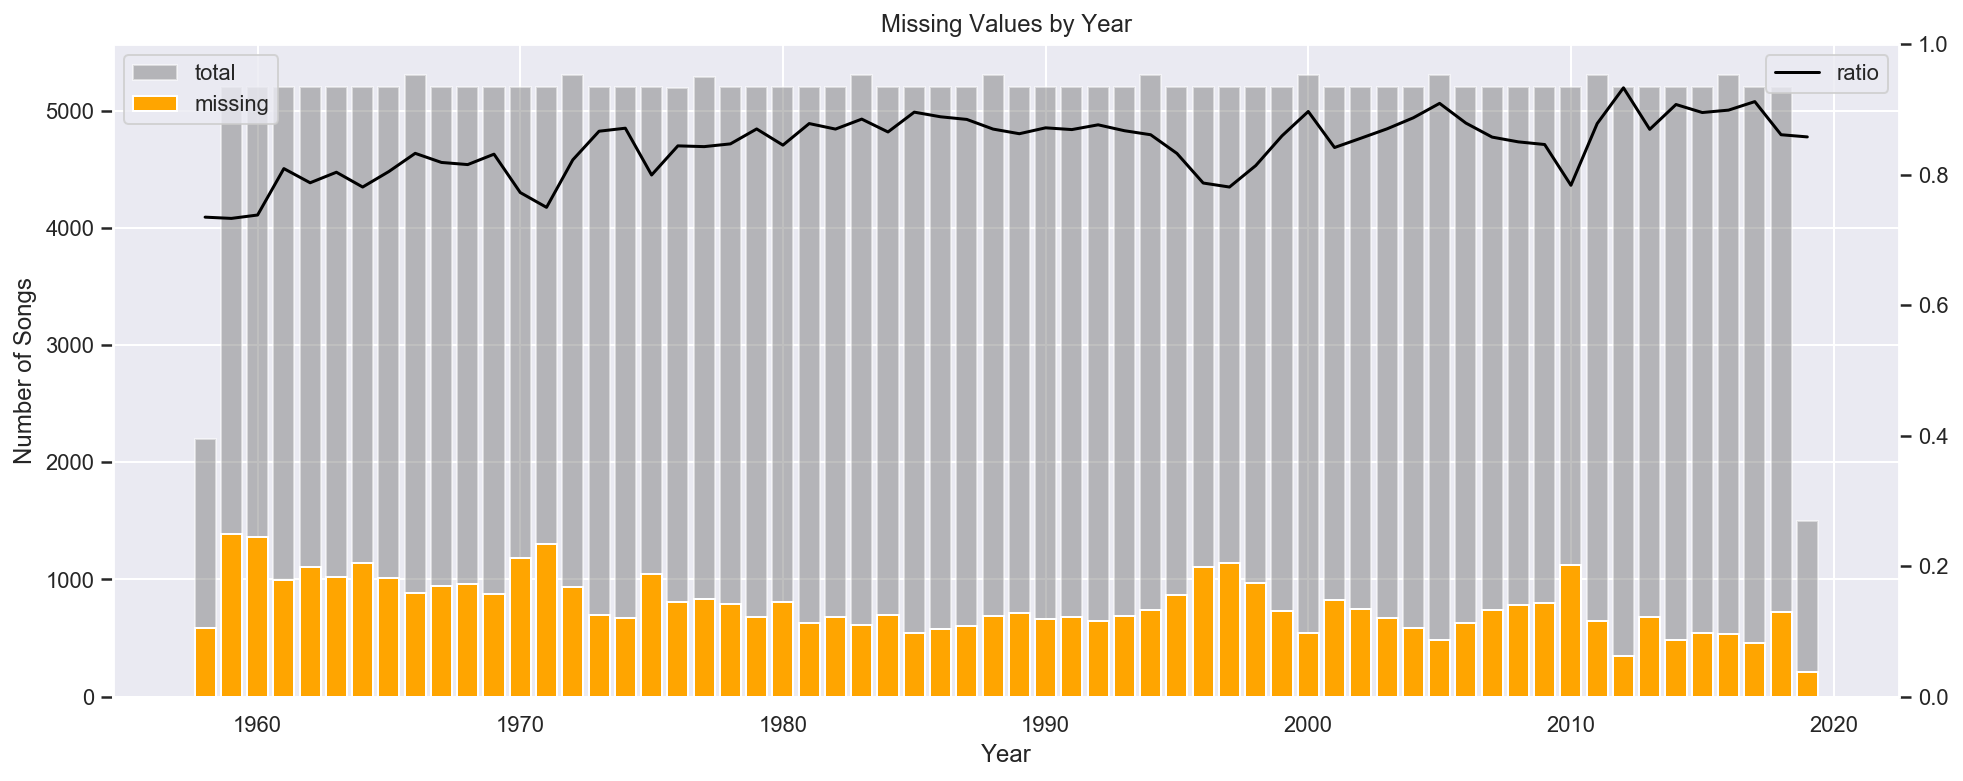

In [29]:
hot100_processed['year'] = hot100_processed.loc[:,'date'].dt.year
hot100_date = hot100_processed.set_index('date')
by_year = hot100_date.groupby(by='year').count().loc[:,['rank','iterator']]
by_year.columns = ['total','complete']
by_year['missing'] = by_year['total'] - by_year['complete']
by_year['ratio'] = by_year['complete'] / by_year['total']

_ = plot_by(x=by_year.index,y=by_year.missing,y_all=by_year.total,y_ratio=by_year.ratio,\
        title='Missing Values by Year',xlabel='Year',ylabel='Number of Songs')

Most missing values are in the late 60s and 70s. The late 80's and early 90's as well as the most recent years show the least amount of missing values but generally the number of missing songs for a year are just below 1/5th (i.e. 20%) for all data, for the periods with higher missing values this number can get close to 1/4th (i.e. 25%).

There are two obvious years that would show incomplete `total` data (e.g. 1958 - the first year - and 2019 - the current year -). Beyond those two years we can see that some years have more than 5200 entries (i.e. 5300 entries). This is due to the fact that the Billboard Hot 100 are released on a Saturday and every so often there are 53 Saturdays in a year (i.e. 1966, 1972, 1977, 1983, etc.).

Lastly, there is slight dip in the years 1976 and 1977 (almost not visible). This is due to missing data on the Billboard Hot 100 charts in the period between 1976-11-22 and 1977-02-28. In this 15 week period exactly one rank/position is missing each week (i.e. 99 songs are on the charts each week for this period). Since this is a minor issue it likely won't affect our model.

In the following we'll check for consistency by rank.

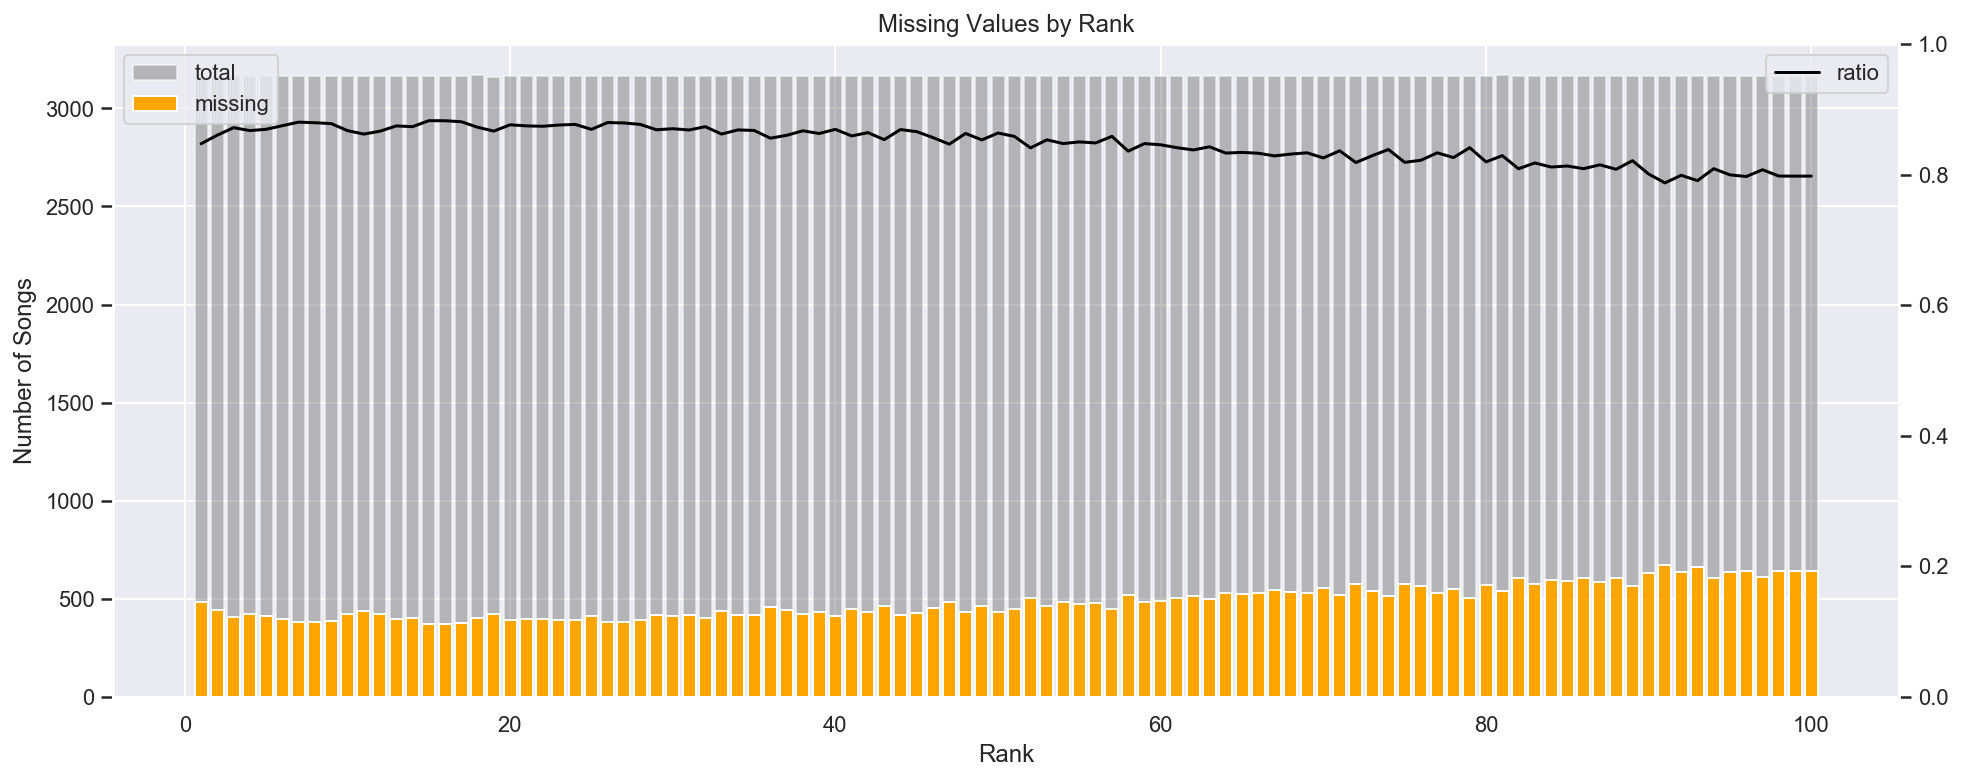

In [30]:
hot100_rank = hot100_processed.set_index('rank')
by_rank = hot100_rank.groupby(by='rank').count().loc[:,['title','iterator']]
by_rank.columns = ['total','complete']
by_rank['missing'] = by_rank['total'] - by_rank['complete']
by_rank['ratio'] = by_rank['complete'] / by_rank['total']

_ = plot_by(x=by_rank.index,y=by_rank.missing,y_all=by_rank.total,y_ratio=by_rank.ratio,\
        title='Missing Values by Rank',xlabel='Rank',ylabel='Number of Songs')

There is no clear trend as to missing values by rank/position. Missing values occur just as often for higher ranks as for lower ranks in our Billboard Hot 100 Charts set. If any trend is visible there might be slightly more missing values towards the lower ranks (toward 100) then in the higher positions, but this trend seems negligible.

Next we'll see how missing values are distributed among unique songs. We'll need to drop any duplicates but since a song can enter and leave at different positions in the Hot 100 chart we'll create a new position identifier that tracks the highest achieved positions (i.e. peak position).

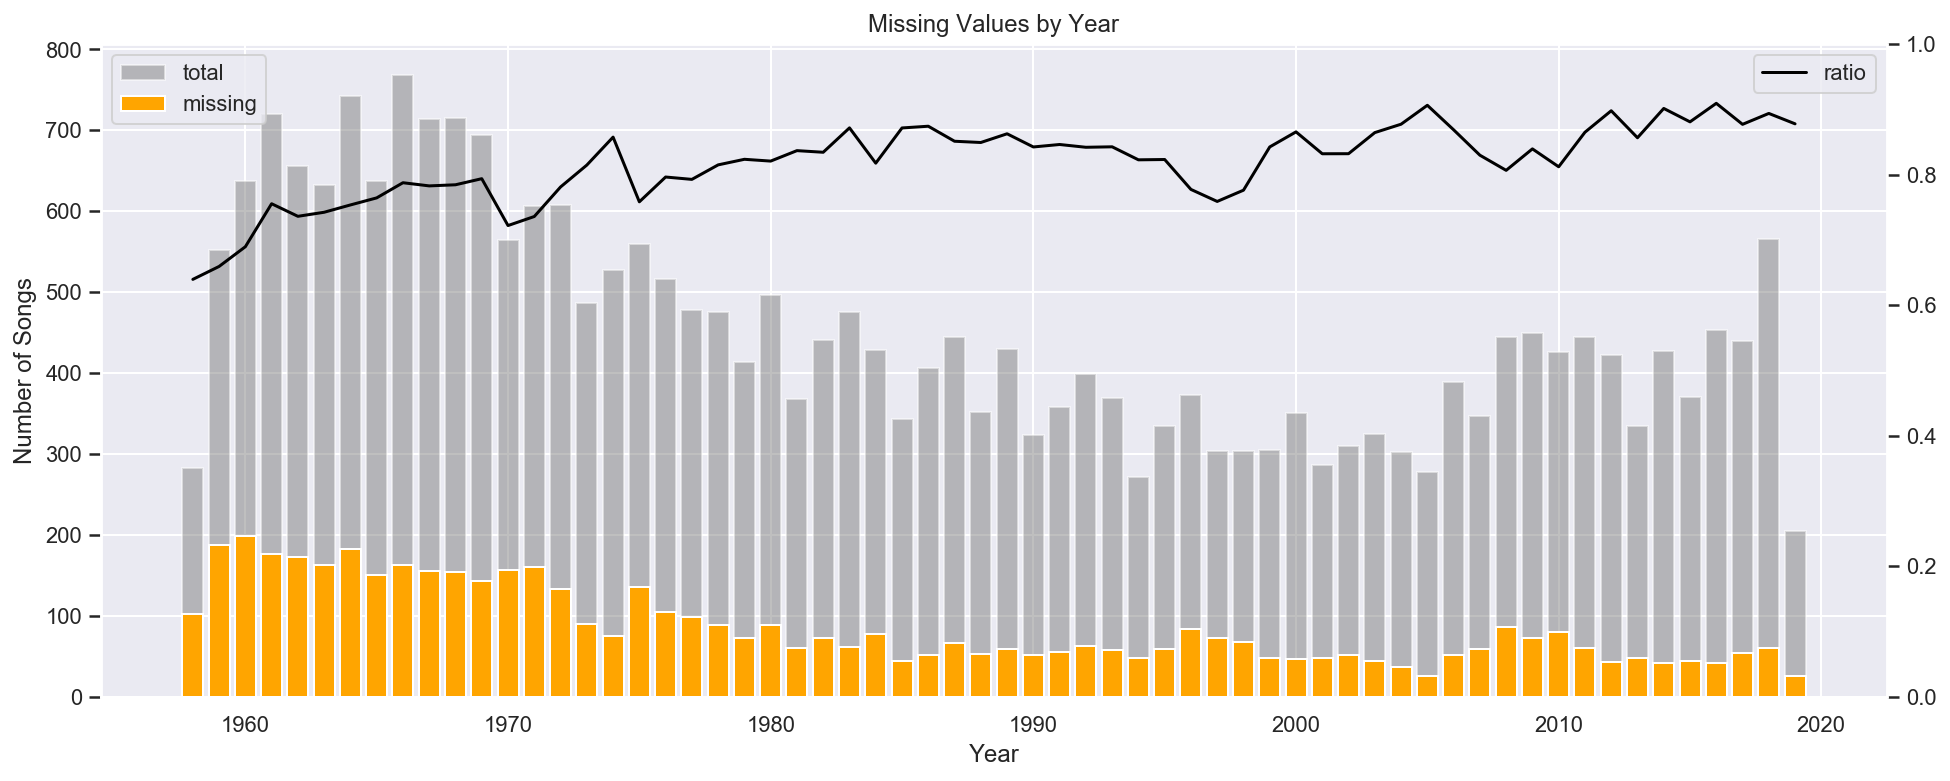

In [31]:
hits_uniq = hot100_processed.drop_duplicates(subset=['artist','title'],keep='first')
hits_uniq = hits_uniq.set_index('date')
by_year_uniq = hits_uniq.groupby(by='year').count().loc[:,['rank','iterator']]
by_year_uniq.columns = ['total','complete']
by_year_uniq['missing'] = by_year_uniq['total'] - by_year_uniq['complete']
# Add a proportion column
by_year_uniq['ratio'] = by_year_uniq['complete'] / by_year_uniq['total']

_ = plot_by(x=by_year_uniq.index,y=by_year_uniq.missing,y_all=by_year_uniq.total,y_ratio=by_year_uniq.ratio,\
        title='Missing Values by Year',xlabel='Year',ylabel='Number of Songs')

Looking at the unique songs, likely the more important metric for our model, we can see a lower number of unique songs in the charts by year in the 90s and early 2000s. This is due to the fact that there is less total fluctuation in the Billboard Hot 100 Charts through time (i.e. songs remain in the charts relatively longer) compared to the 1960s and early 1970s.

That being said we've seen a stagnation of this trend over the past decade with an uptick in recent years (especially 2018).

The overall ratio of complete unique songs to total unique songs ranges between .6 and .9 (i.e. 10% - 40% of songs are missing in any given year). 

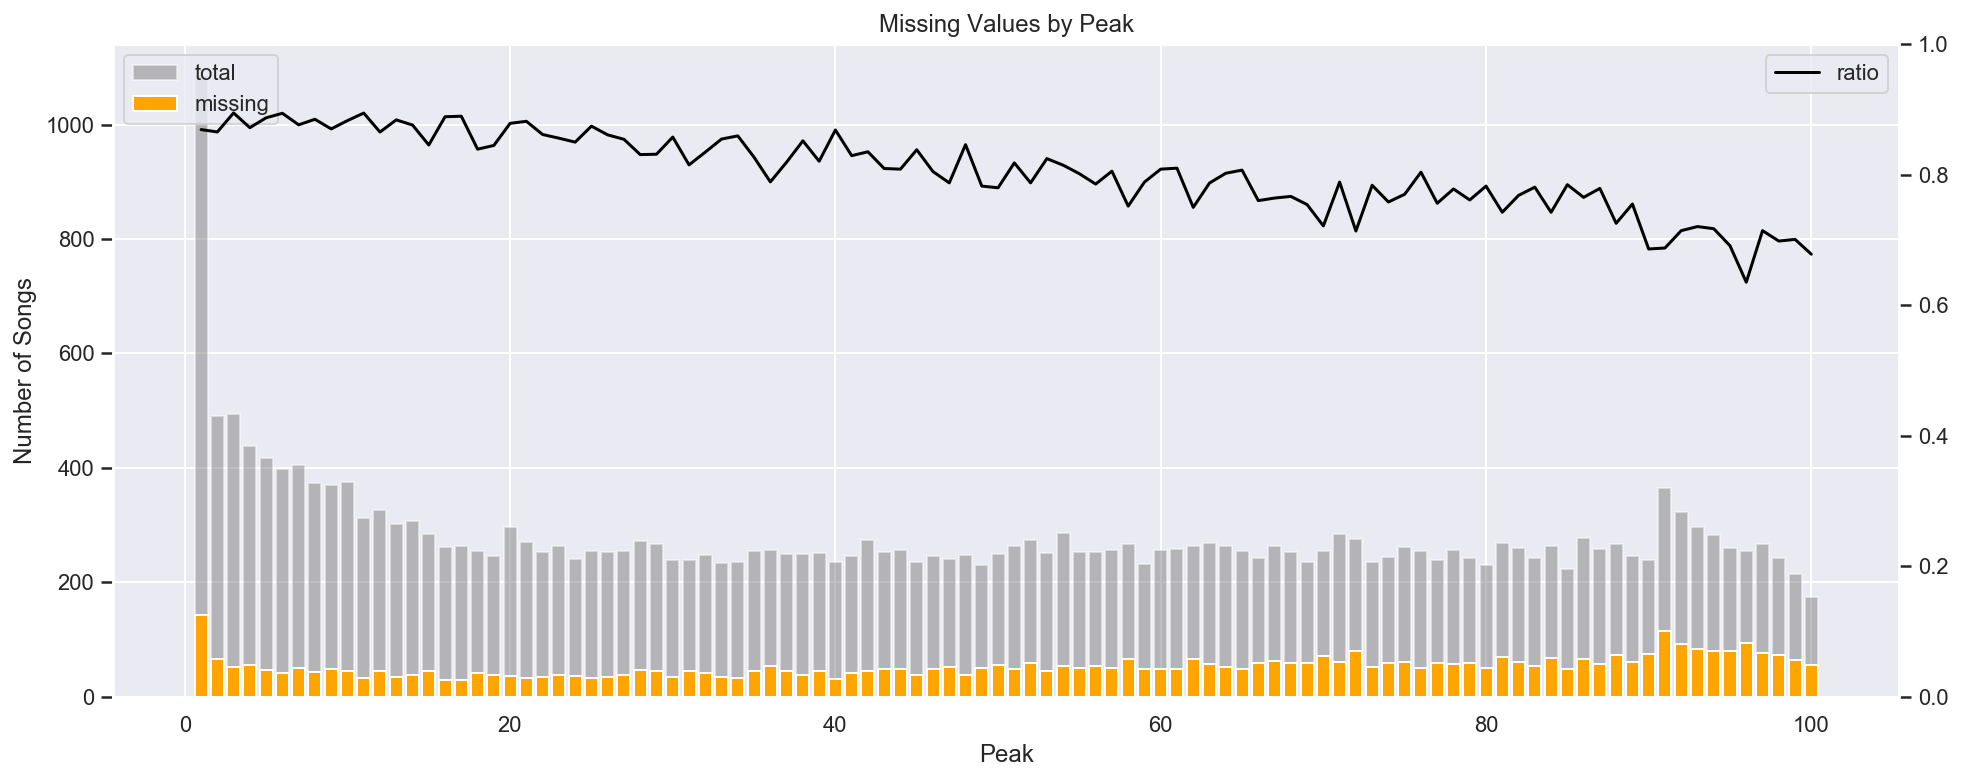

In [32]:
if not 'peak' in hot100_processed.columns:
    peak_ranks = hot100_all.groupby(['title','artist']).min().loc[:,'rank']
    peak_ranks = peak_ranks.rename('peak')
    hot100_processed = hot100_processed.merge(peak_ranks,how='left',on=['title','artist'])

hot100_peak = hot100_processed.sort_values(by=['artist','title','rank'])
hot100_peak = hot100_processed.set_index('peak')
hot100_peak = hot100_processed.drop_duplicates(subset=['artist','title'],keep='first')
by_peak = hot100_peak.groupby(by='peak').count().loc[:,['title','iterator']]
by_peak.columns = ['total','complete']
by_peak['missing'] = by_peak['total'] - by_peak['complete']
by_peak['ratio'] = by_peak['complete'] / by_peak['total']

_ = plot_by(x=by_peak.index,y=by_peak.missing,y_all=by_peak.total,y_ratio=by_peak.ratio,\
        title='Missing Values by Peak',xlabel='Peak',ylabel='Number of Songs')

If we look at the peaks of the unique songs we can see that the pole position (1.) has the most unique songs and hence the most absolute missing values. This shift toward higher positions (lower integers) is expected as the 'peak' feature takes the highest position that was achieved by a song during its time on the hot 100. 

However, looking at the chart proportionally we see a similar trend to the ranks graphs above: the lower positions tend to be less complete than those who've reached higher positions.

As there is little we can do about songs that can't be matched with a Spotify Identifier we unfortunately have to remove those songs from our material.

In [33]:
hot100_processed_no_nan = hot100_processed.dropna(subset=['iterator'])
target_columns =['date','year','rank','peak','popularity','title','artist','filename','id',
               'danceability','energy', 'key', 'loudness', 'mode', 'speechiness', 
               'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 
               'duration_ms', 'type', 'uri','track_href', 'analysis_url', 
               'time_signature']
hot100_processed_no_nan = hot100_processed_no_nan.loc[:,target_columns]

hits_uniq = hot100_processed.drop_duplicates(subset=['artist','title'],keep='first').drop('rank',axis=1)
hits_uniq['orig_artist'] = hits_uniq.loc[:,'artist']
hits_uniq['orig_title'] = hits_uniq.loc[:,'title']
hits_uniq = wrangle_artist_title(hits_uniq,artist_col='orig_artist',title_col='orig_title')
hits_uniq.loc[:,'hit'] = True
hits_uniq_no_nan = hits_uniq.copy()
hits_uniq_no_nan = hits_uniq_no_nan.dropna(subset=['iterator'])
hits_uniq_no_nan = hits_uniq_no_nan.set_index('date')
hits_uniq_by_year = hits_uniq_no_nan.groupby(by='year').count().loc[:,['peak','title']]
hits_uniq_by_year.columns = ['total','complete']

In [34]:
processed_path = '../processed/'
hits_target = 'hits.csv'
hits_uniq_target = 'hits_uniq.csv'

hot100_processed.to_csv(processed_path + hits_target,sep='\t',index=False,encoding='utf-8')

hits_uniq.drop_duplicates(subset=['artist','title'],inplace=True)
hits_uniq.reset_index(inplace=True)
hits_uniq.to_csv(processed_path + hits_uniq_target,sep='\t',index=False,encoding='utf-8')

In [35]:
len(hits_uniq)

28083

In [36]:
hits_uniq.head()

,index,date,year,month,day,title,artist,week,reentry,streak,ranked,entry_date,entry_week,entry,entry_year,entry_month,entry_day,exit_date,exit_week,exit,exit_year,exit_month,exit_day,peak,peak_date,peak_week,peak_year,peak_month,peak_day,leap_week,leap,max_leap,max_leap_date,max_leap_week,max_leap_year,max_leap_month,max_leap_day,low,filename,iterator,popularity,spotify_artist,spotify_title,verified,orig_artist,orig_title,twogram_artist,twogram_title,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,hit
0,0,1967-07-08,1967,7,8,Windy,The Association,7,0,13,14,1967-05-27,1,52,1967,5,27,1967-08-26,14,34,1967,8,26,1,1967-05-27,1,1967,5,27,7,0.0,24.0,1967-06-03,2.0,1967.0,6.0,3.0,52,./data/interim/hot100/hot100_1967-07-03.csv,6RUpOheT93fUdI508K5w6U,45.0,THE ASSOCIATION,WINDY,True,THE ASSOCIATION,WINDY,0.0,0.000000,6RUpOheT93fUdI508K5w6U,0.677,0.722,5.0,-7.767,1.0,0.0295,0.357,0.148000,0.105,0.898,132.996,audio_features,6RUpOheT93fUdI508K5w6U,spotify:track:6RUpOheT93fUdI508K5w6U,https://api.spotify.com/v1/tracks/6RUpOheT93fU...,https://api.spotify.com/v1/audio-analysis/6RUp...,174600.0,4.0,True
1,1,1967-07-08,1967,7,8,Little Bit O' Soul,The Music Explosion,9,0,15,16,1967-05-13,1,90,1967,5,13,1967-08-26,16,46,1967,8,26,2,1967-05-13,1,1967,5,13,9,1.0,33.0,1967-05-27,3.0,1967.0,5.0,27.0,90,./data/interim/hot100/hot100_1967-07-03.csv,75obkRHfYSwnd20wXMreRO,6.0,THE MUSIC EXPLOSION,LITTLE BIT O SOUL ACTION MIX,True,THE MUSIC EXPLOSION,LITTLE BIT O SOUL,0.0,0.433333,75obkRHfYSwnd20wXMreRO,0.602,0.679,7.0,-6.708,1.0,0.0390,0.337,0.000000,0.313,0.889,136.459,audio_features,75obkRHfYSwnd20wXMreRO,spotify:track:75obkRHfYSwnd20wXMreRO,https://api.spotify.com/v1/tracks/75obkRHfYSwn...,https://api.spotify.com/v1/audio-analysis/75ob...,141827.0,4.0,True
2,2,1967-07-08,1967,7,8,Can't Take My Eyes Off You,Frankie Valli,8,0,15,16,1967-05-20,1,74,1967,5,20,1967-09-02,16,35,1967,9,2,2,1967-05-20,1,1967,5,20,8,4.0,21.0,1967-05-27,2.0,1967.0,5.0,27.0,74,NaN,NaN,NaN,NaN,NaN,NaN,FRANKIE VALLI,CANT TAKE MY EYES OFF YOU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,3,1967-07-08,1967,7,8,San Francisco (Be Sure To Wear Flowers In Your...,Scott McKenzie,7,0,11,12,1967-05-27,1,98,1967,5,27,1967-08-12,12,28,1967,8,12,4,1967-05-27,1,1967,5,27,7,0.0,43.0,1967-06-03,2.0,1967.0,6.0,3.0,98,./data/interim/hot100/hot100_1967-07-03.csv,77qBwefBIdzymXNCuAI8YX,52.0,SCOTT MCKENZIE,SAN FRANCISCO BE SURE TO WEAR SOME FLOWERS IN...,True,SCOTT MCKENZIE,SAN FRANCISCO BE SURE TO WEAR FLOWERS IN YOUR...,0.0,0.089286,77qBwefBIdzymXNCuAI8YX,0.495,0.670,7.0,-5.918,1.0,0.0284,0.047,0.000025,0.219,0.478,112.443,audio_features,77qBwefBIdzymXNCuAI8YX,spotify:track:77qBwefBIdzymXNCuAI8YX,https://api.spotify.com/v1/tracks/77qBwefBIdzy...,https://api.spotify.com/v1/audio-analysis/77qB...,178933.0,4.0,True
4,4,1967-07-08,1967,7,8,Don't Sleep In The Subway,Petula Clark,6,0,9,10,1967-06-03,1,76,1967,6,3,1967-08-05,10,42,1967,8,5,5,1967-06-03,1,1967,6,3,6,5.0,27.0,1967-06-10,2.0,1967.0,6.0,10.0,76,./data/interim/hot100/hot100_1967-07-03.csv,1ljijVo7rDHSuXIhydPpNl,41.0,PETULA CLARK,DONT SLEEP IN THE SUBWAY,True,PETULA CLARK,DONT SLEEP IN THE SUBWAY,0.0,0.000000,1ljijVo7rDHSuXIhydPpNl,0.394,0.486,10.0,-9.742,1.0,0.0366,0.627,0.000000,0.167,0.427,133.685,audio_features,1ljijVo7rDHSuXIhydPpNl,spotify:track:1ljijVo7rDHSuXIhydPpNl,https://api.spotify.com/v1/tracks/1ljijVo7rDHS...,https://api.spotify.com/v1/audio-analysis/1lji...,175373.0,4.0,True


The data distribution by year without missing values resembles roughly the distribution of songs with missing values. Therefore we'll be content with these results for now and are going to divert our attention to the second set of songs that have not made it into the Hot 100.

# Sampling Spotify Data

In the next step we'll generate a sample from Spotify data that roughly resembles the distribution by year we've seen in the Hot 100 data. To capture the breadth of various songs we'll sample ~20% of our spotify songs from the 10% least popular songs on Spotify. This is taking into account that by using the Spotify Search we're only able to sample from the 10000 most popular songs of a year (according to Spotify their popularity score tends to emphasize CURRENT popularity).

To avoid sampling too many overly popular songs we're going to take random samples from the first 10000 search results (in chunks of 50 songs) and we're going to slightly oversample so as to be able to remove the overlap in a later step.

In [37]:
from pprint import pprint
import json
import ast
import spotipy
import random
import math
from spotipy.oauth2 import SpotifyClientCredentials
import os
from dotenv import load_dotenv

dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

client_credentials_manager = SpotifyClientCredentials(client_id=os.getenv("SPOTIFY_CLIENT_ID"), client_secret=os.getenv("SPOTIFY_CLIENT_SECRET"))
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

def round_up(x, base=50):
    return base * math.ceil(x/base)

target_path = '../interim/spotify_songs.csv'

try:
    sampling_df = pd.read_csv(target_path,sep='\t',parse_dates=['album.release_date'])
except:
    print('Sampling Songs from Spotify - Beware that a client and secret is necessary for this method.')
    
    output_filepath = '../interim/'
    temp_dir = 'spotify_sampling_temp'
    skip = 0

    if not os.path.exists(output_filepath + temp_dir):
        os.mkdir(output_filepath + temp_dir)
    else:
        for file in iglob(output_filepath + temp_dir + '/*.csv'):
            m = re.search('sampling_([0-9]+?).csv$', file)
            if m:
                file_nr = int(m.group(1))
                if file_nr > skip:
                    skip = file_nr
    
    # Seed random function            
    np.random.seed(500)
    
    # Sampling Additional Songs By Year
    years = sorted(hits_uniq['year'].unique())
    spotify_song_sets = []
    ceil_to = 100
    for i, year in enumerate(years):
        file_nr = i + 1
        if file_nr <= skip:
            print('skip:', file_nr)
            continue
        start = 0
        tracks = []
        len_hot100 = len(hits_uniq_no_nan.loc[hits_uniq['year'] == year,'year'])
        print(year)
        print("Number of Songs for {}: {}".format(year,len_hot100))
        len_k_tracks = round_up(len_hot100 * 0.8,base=ceil_to)
        k = int(len_k_tracks / 50)
        len_low_k_tracks = round_up(len_hot100 * 0.2,base=ceil_to)
        low_k = int(len_low_k_tracks / 50)
        print("Number of Songs Sampled from high popularity: {}".format(len_k_tracks))
        print("Number of Songs Sampled from low popularity: {}".format(len_low_k_tracks))
        offsets = (x for x in np.random.choice(np.arange(0,10000,50),k,replace=False))
        while len(tracks) < len_k_tracks:
            offset = next(offsets)
            tracks.extend(sp.search(q='year:' + str(year),type='track',limit=50,offset=offset,market='us')['tracks']['items'])
        # Fetch Hipster Tags (lowest 10% popularity)
        start = 0
        while (len(tracks) - len_k_tracks) < len_low_k_tracks:
            tracks.extend(sp.search(q='year:' + str(year),type='track',limit=50,offset=start,market='us')['tracks']['items'])
            start = start + 50
        time.sleep(3)
        spotify_songs = pd.DataFrame(pd.io.json.json_normalize(tracks))
        
        spotify_songs.to_csv(output_filepath + temp_dir + '/sampling_' + str(file_nr) + '.csv',sep='\t',index=False)
    
    subfiles_sampling = [pd.read_csv(file,sep='\t') for file in iglob(output_filepath + temp_dir + '/sampling_*.csv')]

    sampling_df = pd.concat(subfiles_sampling).reset_index(drop=True)
    sampling_df.to_csv(target_path,sep='\t',index=False)
    
    # Clean up temp files
    [os.remove(file) for file in iglob(output_filepath + temp_dir + '/sampling_*.csv')]
    try:
        os.remove(output_filepath + temp_dir + '/.DS_Store')
    except:
        print('No .DS_Store file. You\'re all set!')

    os.rmdir(output_filepath + temp_dir)

sampling_df.head()

,album.album_type,album.artists,album.external_urls.spotify,album.href,album.id,album.images,album.name,album.release_date,album.release_date_precision,album.total_tracks,album.type,album.uri,artists,disc_number,duration_ms,explicit,external_ids.isrc,external_urls.spotify,href,id,is_local,is_playable,name,popularity,preview_url,restrictions.reason,track_number,type,uri
0,compilation,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/1J9X5FXcbhoAvsJ...,https://api.spotify.com/v1/albums/1J9X5FXcbhoA...,1J9X5FXcbhoAvsJn8aJPTO,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Catch The Rainbow: The Anthology,2003-03-18,day,28,album,spotify:album:1J9X5FXcbhoAvsJn8aJPTO,[{'external_urls': {'spotify': 'https://open.s...,2,282226,False,USF068200010,https://open.spotify.com/track/3njS1B9vpX9SMiI...,https://api.spotify.com/v1/tracks/3njS1B9vpX9S...,3njS1B9vpX9SMiIiIIdlI5,False,True,Death Alley Driver,29,NaN,NaN,9,track,spotify:track:3njS1B9vpX9SMiIiIIdlI5
1,compilation,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/1ZyeNQ6uvVyK3yN...,https://api.spotify.com/v1/albums/1ZyeNQ6uvVyK...,1ZyeNQ6uvVyK3yNJDSLdRU,"[{'height': 579, 'url': 'https://i.scdn.co/ima...",Playlist: The Very Best Of Los Lonely Boys,2003-01-01,year,14,album,spotify:album:1ZyeNQ6uvVyK3yNJDSLdRU,[{'external_urls': {'spotify': 'https://open.s...,1,245480,False,USSM10601201,https://open.spotify.com/track/3oHawpLmh9MO2zG...,https://api.spotify.com/v1/tracks/3oHawpLmh9MO...,3oHawpLmh9MO2zGAZ2I7Uw,False,True,Texican Style,19,https://p.scdn.co/mp3-preview/71937bc34ca89b54...,NaN,9,track,spotify:track:3oHawpLmh9MO2zGAZ2I7Uw
2,album,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/67nk667gnOpJgka...,https://api.spotify.com/v1/albums/67nk667gnOpJ...,67nk667gnOpJgkaqe2XJF8,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Giving the Devil His Due,2003-08-17,day,20,album,spotify:album:67nk667gnOpJgkaqe2XJF8,[{'external_urls': {'spotify': 'https://open.s...,1,292493,False,NLA329880324,https://open.spotify.com/track/3qQ0kNXN7MwG5tl...,https://api.spotify.com/v1/tracks/3qQ0kNXN7MwG...,3qQ0kNXN7MwG5tlFSq0iuM,False,True,Blisters,24,https://p.scdn.co/mp3-preview/2ef08b26b8e3251b...,NaN,7,track,spotify:track:3qQ0kNXN7MwG5tlFSq0iuM
3,album,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/1EX8VrF5sQKyYcq...,https://api.spotify.com/v1/albums/1EX8VrF5sQKy...,1EX8VrF5sQKyYcq1IQD4ls,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Cold Mountain (Music From the Miramax Motion P...,2003-12-16,day,19,album,spotify:album:1EX8VrF5sQKyYcq1IQD4ls,[{'external_urls': {'spotify': 'https://open.s...,1,191893,False,USSM10314654,https://open.spotify.com/track/3sYtXKuJ5wGFu5s...,https://api.spotify.com/v1/tracks/3sYtXKuJ5wGF...,3sYtXKuJ5wGFu5sKtyOGcx,False,True,Ruby With The Eyes That Sparkle,22,https://p.scdn.co/mp3-preview/d70576167c292200...,NaN,12,track,spotify:track:3sYtXKuJ5wGFu5sKtyOGcx
4,album,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/7JH1bTXeOyysfVK...,https://api.spotify.com/v1/albums/7JH1bTXeOyys...,7JH1bTXeOyysfVKkOYScrC,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Connected to You 5M,2003-01-01,year,12,album,spotify:album:7JH1bTXeOyysfVKkOYScrC,[{'external_urls': {'spotify': 'https://open.s...,1,174000,False,JPKS00301526,https://open.spotify.com/track/3v5PMsmTygnuEHS...,https://api.spotify.com/v1/tracks/3v5PMsmTygnu...,3v5PMsmTygnuEHSP16rAVy,False,True,N.G.S,23,https://p.scdn.co/mp3-preview/b520ba5fca3fbffe...,NaN,8,track,spotify:track:3v5PMsmTygnuEHSP16rAVy


In [38]:
sampling_df['album.release_date'] \
    + pd.to_timedelta((6 - sampling_df['album.release_date'].dt.dayofweek), unit='d')

0       2003-03-23
1       2003-01-05
2       2003-08-17
3       2003-12-21
4       2003-01-05
5       2003-07-06
6       2003-05-11
7       2003-01-05
8       2003-12-21
9       2003-01-05
10      2003-01-05
11      2003-01-05
12      2003-01-05
13      2003-01-05
14      2003-01-05
15      2003-01-05
16      2003-07-27
17      2003-01-05
18      2003-01-05
19      2003-01-26
20      2003-01-05
21      2003-02-02
22      2003-01-05
23      2003-08-03
24      2003-01-05
25      2003-01-05
26      2003-08-31
27      2003-06-29
28      2003-01-05
29      2003-01-05
30      2003-01-05
31      2003-11-09
32      2003-07-13
33      2003-12-21
34      2003-04-27
35      2003-01-05
36      2003-11-30
37      2003-01-05
38      2003-09-07
39      2003-01-12
40      2003-01-05
41      2003-01-05
42      2003-01-05
43      2003-01-05
44      2003-10-12
45      2003-02-02
46      2003-01-05
47      2003-01-05
48      2003-01-05
49      2003-05-11
50      2003-11-30
51      2003-11-30
52      2003

In [39]:
# Create String of artists
sampling_df['artist'] = [' + '.join([artist['name'] for artist in ast.literal_eval(artists)]) for artists in sampling_df['artists']]
sampling_df['album.release_date'] = pd.to_datetime(sampling_df['album.release_date'])
sampling_df.rename(columns={'name':'title'},inplace=True)
# Add or deduct days of 'album.release_date' to get to the following Saturday (Hot 100 dates are set as Saturdays)
saturday = 5
sampling_df['date'] = sampling_df['album.release_date'] + pd.to_timedelta((saturday - sampling_df['album.release_date'].dt.dayofweek), unit='d')
sampling_df['year'] = sampling_df['date'].dt.year
sampling_df['month'] = sampling_df['date'].dt.month
sampling_df['day'] = sampling_df['date'].dt.day
spotify_songs = sampling_df.loc[:,['id','title','artist','album.id','album.name','year','month','day','date','album.release_date','duration_ms','popularity','uri']]
spotify_songs = spotify_songs.drop_duplicates()
spotify_songs.head()

,id,title,artist,album.id,album.name,year,month,day,date,album.release_date,duration_ms,popularity,uri
0,3njS1B9vpX9SMiIiIIdlI5,Death Alley Driver,Rainbow,1J9X5FXcbhoAvsJn8aJPTO,Catch The Rainbow: The Anthology,2003,3,22,2003-03-22,2003-03-18,282226,29,spotify:track:3njS1B9vpX9SMiIiIIdlI5
1,3oHawpLmh9MO2zGAZ2I7Uw,Texican Style,Los Lonely Boys,1ZyeNQ6uvVyK3yNJDSLdRU,Playlist: The Very Best Of Los Lonely Boys,2003,1,4,2003-01-04,2003-01-01,245480,19,spotify:track:3oHawpLmh9MO2zGAZ2I7Uw
2,3qQ0kNXN7MwG5tlFSq0iuM,Blisters,Coal Chamber,67nk667gnOpJgkaqe2XJF8,Giving the Devil His Due,2003,8,16,2003-08-16,2003-08-17,292493,24,spotify:track:3qQ0kNXN7MwG5tlFSq0iuM
3,3sYtXKuJ5wGFu5sKtyOGcx,Ruby With The Eyes That Sparkle,Stuart Duncan + Dirk Powell,1EX8VrF5sQKyYcq1IQD4ls,Cold Mountain (Music From the Miramax Motion P...,2003,12,20,2003-12-20,2003-12-16,191893,22,spotify:track:3sYtXKuJ5wGFu5sKtyOGcx
4,3v5PMsmTygnuEHSP16rAVy,N.G.S,ASIAN KUNG-FU GENERATION,7JH1bTXeOyysfVKkOYScrC,Connected to You 5M,2003,1,4,2003-01-04,2003-01-01,174000,23,spotify:track:3v5PMsmTygnuEHSP16rAVy


In [40]:
spotify_songs['orig_artist'] = spotify_songs.loc[:,'artist']
spotify_songs['orig_title'] = spotify_songs.loc[:,'title']

spotify_songs = wrangle_artist_title(spotify_songs,artist_col='orig_artist',title_col='orig_title')

duplicates = pd.merge(hits_uniq.loc[:,['orig_artist','orig_title']],spotify_songs.loc[:,['orig_artist','orig_title']],on=['orig_artist','orig_title'],how='inner')

spotify_songs['orig_artist_title'] = spotify_songs['orig_artist'] + ' ' + spotify_songs['orig_title']
duplicates['orig_artist_title'] = duplicates['orig_artist'] + ' ' + duplicates['orig_title']

In [41]:
# Remove Songs that are also in the Hot 100
nhits = spotify_songs.loc[~(spotify_songs['id'].isin(hot100_processed['iterator']) | spotify_songs['orig_artist_title'].isin(duplicates['orig_artist_title'])),:]
overlap = spotify_songs.loc[spotify_songs['id'].isin(hot100_processed['iterator']) | spotify_songs['orig_artist_title'].isin(duplicates['orig_artist_title']),:]
print("{} Songs had to be removed as they overlap with Hot 100 Data".format(len(overlap)))

4548 Songs had to be removed as they overlap with Hot 100 Data


Total Spotify Songs: 23664
Total Hot 100 Songs: 22761
Spotify to Hot 100 ratio: 1.0397
Spotify/Total: 50.970000000000006%


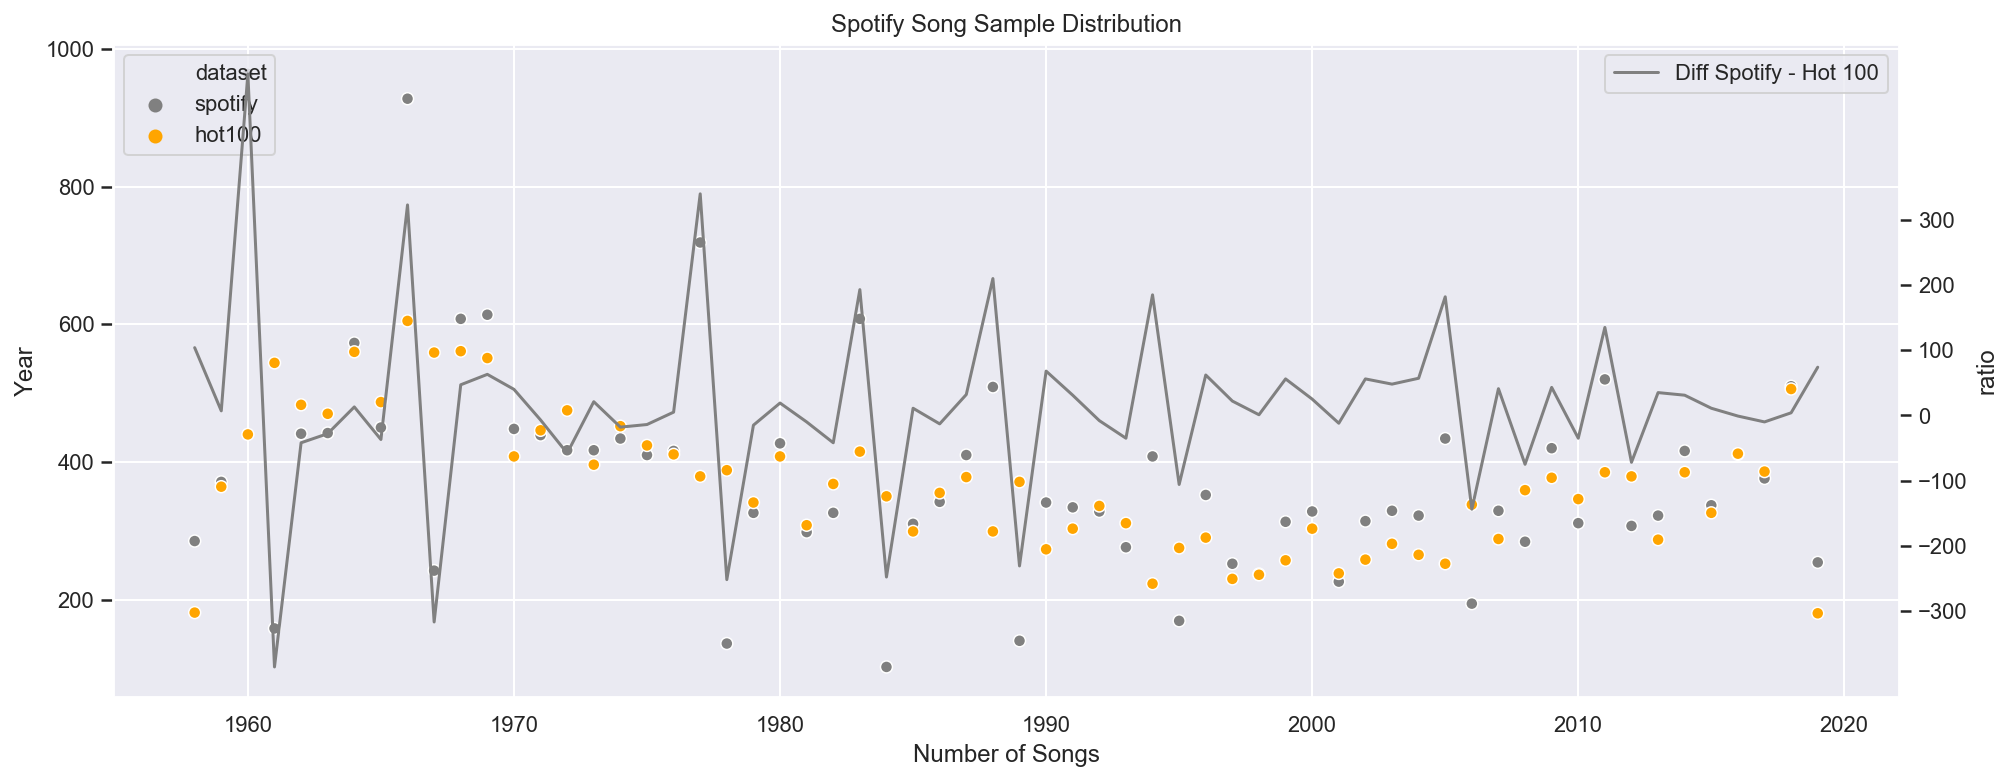

In [42]:
years = len(nhits['year'].unique())
spotify_uniq_by_year = nhits.groupby(by='year').count()

fig = plt.figure(figsize=(16,6))
data=pd.concat([spotify_uniq_by_year['id'],hits_uniq_by_year['total']],axis=1)
data.columns = ['spotify','hot100']

data_ratio = pd.DataFrame(index=data.index)
data_ratio['ratio'] = (data['spotify'] - data['hot100'])
data_ratio.reset_index(inplace=True)

data.reset_index(inplace=True)
data = data.melt(id_vars=['year'])
data.columns = ['year','dataset','value']

title='Spotify Song Sample Distribution'
ylabel='Year'
xlabel='Number of Songs'

_ = sns.scatterplot(x='year',y='value',hue='dataset',data=data)
_ = plt.title(title)
_ = plt.xlabel(xlabel)
_ = plt.ylabel(ylabel)
_ = plt.legend(loc='upper left')
_ = plt.twinx()
_ = sns.lineplot(x='year',y='ratio',data=data_ratio,label='Diff Spotify - Hot 100')
_ = plt.legend(loc='upper right')
_ = plt.yticks(np.arange(-300,350,100))
_ = plt.grid(False)

total_spotify = data.loc[data['dataset'] == 'spotify','value'].sum()
total_hot100 = data.loc[data['dataset'] == 'hot100','value'].sum()
print("Total Spotify Songs: {}\nTotal Hot 100 Songs: {}\nSpotify to Hot 100 ratio: {}\nSpotify/Total: {}%".format(total_spotify,total_hot100,round(total_spotify/total_hot100,4),round(total_spotify/(total_spotify+total_hot100),4)*100))

The above graph shows the Spotify Sample compared to the Hot 100 Data. We can see that the two datasets are almost equally distributed. The Line Graph ("Diff Spotify Hot 100") shows absolute count differences between Spotify and the Hot 100 Data and we can see that the Spotify song set is minimally larger (i.e. Spotify songs make up 51.92% of all songs).

In [43]:
# Create Iterator for data set 
spotify_songs_iterator = nhits.drop_duplicates()['id'].to_frame()
spotify_songs_iterator.columns = ['iterator']
spotify_songs_iterator.to_csv('../iterators/spotify_songs_ids_iterator.csv',sep='\t',index=False,encoding='utf-8')

The above code outputs an iterator csv for scraping the spotify features for our non-hits (spotify sample). Which we're going to read into a DataFrame below for creating the processed file.

In [44]:
# Read in all Subfiles
filenames = glob('comparison_data_analysis_api/*.csv')
nhits_analysis_dfs = [pd.read_csv(filepath,sep='\t') for filepath in filenames]
nhits_analysis_all = pd.concat(nhits_analysis_dfs,sort=True)
nhits_analysis_all.rename(columns={'name':'iterator'}, inplace=True)
nhits_analysis_all.head()

nhits.drop(['duration_ms','uri'],axis=1,inplace=True)

nhits_processed = nhits.merge(nhits_analysis_all,on=['id'],how='left')
print("Length of all nhits and merged nhits_processed match: {} ({})".format(len(nhits_processed) == len(nhits),len(nhits_processed)))

Length of all nhits and merged nhits_processed match: True (23664)


/Users/sebastian/anaconda3/envs/hit_predictor/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [45]:
# Fill in metrics for songs of duplicates into hits df
merged_songs = pd.merge(hits_uniq.loc[:,['orig_artist','orig_title','id']],spotify_songs.loc[:,['orig_artist','orig_title','id']],on=['orig_artist','orig_title'],how='inner')
matched_songs = merged_songs.loc[merged_songs['id_x'].isnull(),:]

matched_songs.loc[:,'orig_artist_title'] = matched_songs['orig_artist'] + ' ' + matched_songs['orig_title']
hits_uniq.loc[:,'orig_artist_title'] = hits_uniq['orig_artist'] + ' ' + hits_uniq['orig_title']

hits_uniq = hits_uniq.merge(matched_songs.loc[:,['orig_artist_title','id_y']],on='orig_artist_title',how='left')
hits_uniq.loc[(hits_uniq['id'].isnull()) & (~hits_uniq['id_y'].isnull()),'id'] = hits_uniq.loc[(hits_uniq['id'].isnull()) & (~hits_uniq['id_y'].isnull()),'id_y']
hits_uniq.drop('id_y',axis=1,inplace=True)

/Users/sebastian/anaconda3/envs/hit_predictor/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/sebastian/anaconda3/envs/hit_predictor/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [46]:
nhits_analysis_cols = list(nhits_analysis_all.columns)
nhits_analysis_cols.remove('id')
rel_columns = ~hits_uniq.columns.isin(nhits_analysis_cols)
hits_uniq_id_idx = hits_uniq.set_index('id')
nhits_analysis_id_idx = nhits_analysis_all.set_index('id')
nhits_analysis_id_idx = nhits_analysis_id_idx.loc[nhits_analysis_id_idx.index.isin(hits_uniq_id_idx.index),:]

hits_uniq = hits_uniq_id_idx.combine_first(nhits_analysis_id_idx).reset_index().loc[:,hits_uniq.columns]

In [47]:
nhits_processed.loc[nhits_processed['tempo'].isnull(),:]

,id,title,artist,album.id,album.name,year,month,day,date,album.release_date,popularity,orig_artist,orig_title,orig_artist_title,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,iterator,speechiness,tempo,time_signature,track_href,type,uri,valence
19869,2XNC8i43ZVOyrMqhqiU6pS,"Vier Lieder für Gesang und Klavier, Op. 12: I....",Anton Webern + Charles Rosen,7wQkvZL8plhG2TkEOKblgS,Charles Rosen Plays Modern Piano Music,1960,12,31,1960-12-31,1961-01-01,0,ANTON WEBERN + CHARLES ROSEN,VIER LIEDER FÜR GESANG UND KLAVIER OP 12: I D...,ANTON WEBERN + CHARLES ROSEN VIER LIEDER FÜR G...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
target_columns = ['date','year','month','day','title','artist','popularity','id','album.id','album.name',
                    'album.release_date','danceability','energy','key','loudness','mode',
                    'speechiness','acousticness','instrumentalness','liveness','valence',
                    'tempo','duration_ms','type','uri','track_href','analysis_url','time_signature']
nhits_processed = nhits_processed.loc[:,target_columns]

# Rename album.release_date to 
nhits_processed.loc[:,'hit'] = False
nhits_processed.columns

Index(['date', 'year', 'month', 'day', 'title', 'artist', 'popularity', 'id',
       'album.id', 'album.name', 'album.release_date', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'type', 'uri', 'track_href', 'analysis_url', 'time_signature', 'hit'],
      dtype='object')

In [49]:
nhits_processed.head()

,date,year,month,day,title,artist,popularity,id,album.id,album.name,album.release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,type,uri,track_href,analysis_url,time_signature,hit
0,2003-03-22,2003,3,22,Death Alley Driver,Rainbow,29,3njS1B9vpX9SMiIiIIdlI5,1J9X5FXcbhoAvsJn8aJPTO,Catch The Rainbow: The Anthology,2003-03-18,0.431,0.736,11.0,-12.577,0.0,0.0434,0.000524,0.000219,0.0919,0.619,104.199,282227.0,audio_features,spotify:track:3njS1B9vpX9SMiIiIIdlI5,https://api.spotify.com/v1/tracks/3njS1B9vpX9S...,https://api.spotify.com/v1/audio-analysis/3njS...,4.0,False
1,2003-01-04,2003,1,4,Texican Style,Los Lonely Boys,19,3oHawpLmh9MO2zGAZ2I7Uw,1ZyeNQ6uvVyK3yNJDSLdRU,Playlist: The Very Best Of Los Lonely Boys,2003-01-01,0.580,0.683,5.0,-4.244,1.0,0.0432,0.017700,0.000005,0.0993,0.508,87.963,245480.0,audio_features,spotify:track:3oHawpLmh9MO2zGAZ2I7Uw,https://api.spotify.com/v1/tracks/3oHawpLmh9MO...,https://api.spotify.com/v1/audio-analysis/3oHa...,4.0,False
2,2003-08-16,2003,8,16,Blisters,Coal Chamber,24,3qQ0kNXN7MwG5tlFSq0iuM,67nk667gnOpJgkaqe2XJF8,Giving the Devil His Due,2003-08-17,0.273,0.829,6.0,-4.749,1.0,0.0496,0.000266,0.001450,0.0915,0.405,146.740,292493.0,audio_features,spotify:track:3qQ0kNXN7MwG5tlFSq0iuM,https://api.spotify.com/v1/tracks/3qQ0kNXN7MwG...,https://api.spotify.com/v1/audio-analysis/3qQ0...,4.0,False
3,2003-12-20,2003,12,20,Ruby With The Eyes That Sparkle,Stuart Duncan + Dirk Powell,22,3sYtXKuJ5wGFu5sKtyOGcx,1EX8VrF5sQKyYcq1IQD4ls,Cold Mountain (Music From the Miramax Motion P...,2003-12-16,0.432,0.141,2.0,-16.811,1.0,0.0418,0.939000,0.660000,0.1930,0.900,171.733,191893.0,audio_features,spotify:track:3sYtXKuJ5wGFu5sKtyOGcx,https://api.spotify.com/v1/tracks/3sYtXKuJ5wGF...,https://api.spotify.com/v1/audio-analysis/3sYt...,4.0,False
4,2003-01-04,2003,1,4,N.G.S,ASIAN KUNG-FU GENERATION,23,3v5PMsmTygnuEHSP16rAVy,7JH1bTXeOyysfVKkOYScrC,Connected to You 5M,2003-01-01,0.418,0.675,9.0,-7.018,0.0,0.0344,0.000070,0.053800,0.1240,0.676,155.019,174000.0,audio_features,spotify:track:3v5PMsmTygnuEHSP16rAVy,https://api.spotify.com/v1/tracks/3v5PMsmTygnu...,https://api.spotify.com/v1/audio-analysis/3v5P...,4.0,False


In [50]:
nhits_processed_no_nan = nhits_processed.dropna(subset=['analysis_url']).drop_duplicates(subset=['id'])
print(len(nhits_processed_no_nan))
processed_path = '../processed/'
nhits_target = 'nhits_uniq.csv'
nhits_processed_no_nan.to_csv(processed_path + nhits_target,sep='\t',index=False,encoding='utf-8')

23663


# Train and Test Set

In this section we'll create train and test sets.

In [51]:
nhits.head()

,id,title,artist,album.id,album.name,year,month,day,date,album.release_date,popularity,orig_artist,orig_title,orig_artist_title
0,3njS1B9vpX9SMiIiIIdlI5,Death Alley Driver,Rainbow,1J9X5FXcbhoAvsJn8aJPTO,Catch The Rainbow: The Anthology,2003,3,22,2003-03-22,2003-03-18,29,RAINBOW,DEATH ALLEY DRIVER,RAINBOW DEATH ALLEY DRIVER
1,3oHawpLmh9MO2zGAZ2I7Uw,Texican Style,Los Lonely Boys,1ZyeNQ6uvVyK3yNJDSLdRU,Playlist: The Very Best Of Los Lonely Boys,2003,1,4,2003-01-04,2003-01-01,19,LOS LONELY BOYS,TEXICAN STYLE,LOS LONELY BOYS TEXICAN STYLE
2,3qQ0kNXN7MwG5tlFSq0iuM,Blisters,Coal Chamber,67nk667gnOpJgkaqe2XJF8,Giving the Devil His Due,2003,8,16,2003-08-16,2003-08-17,24,COAL CHAMBER,BLISTERS,COAL CHAMBER BLISTERS
3,3sYtXKuJ5wGFu5sKtyOGcx,Ruby With The Eyes That Sparkle,Stuart Duncan + Dirk Powell,1EX8VrF5sQKyYcq1IQD4ls,Cold Mountain (Music From the Miramax Motion P...,2003,12,20,2003-12-20,2003-12-16,22,STUART DUNCAN + DIRK POWELL,RUBY WITH THE EYES THAT SPARKLE,STUART DUNCAN + DIRK POWELL RUBY WITH THE EYES...
4,3v5PMsmTygnuEHSP16rAVy,N.G.S,ASIAN KUNG-FU GENERATION,7JH1bTXeOyysfVKkOYScrC,Connected to You 5M,2003,1,4,2003-01-04,2003-01-01,23,ASIAN KUNG FU GENERATION,NGS,ASIAN KUNG FU GENERATION NGS


In [52]:
from sklearn.model_selection import train_test_split

combined = pd.concat([nhits_processed_no_nan,hits_uniq],sort=True)
X = combined.copy()
y = combined.loc[:,['id','hit']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [53]:
X_train.to_csv(processed_path + 'train.csv',sep='\t',index=False,encoding='utf-8')
X_test.to_csv(processed_path + 'test.csv',sep='\t',index=False,encoding='utf-8')